### load the dataset for training 

In [9]:
import csv 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [4]:

inputs = []
outputs = []

with open('acs_data2.csv', 'r') as f:

    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
    
        if line_count <= 1: 
            #ignore headers 
            input_labels = row[1:13]
            output_labels = row[-7:]
            line_count+=1 
            continue 
        
        in1 = [float(i) for i in row[1:13]]
        out1 = [float(i) for i in row[-7:]]
        
        inputs.append(in1)
        outputs.append(out1)
        
        line_count+= 1
        
xdat = np.array(inputs)
ydat = np.array(outputs)


In [5]:
input_labels, "\n", output_labels

(['Heat Rate 1 [C/min]',
  'Ramp 1 Duration [min]',
  'Temperature Dwell 1 [min]',
  'Heat Rate 2 [C/min]',
  'Ramp 2 Duration [min]',
  'Temperature Dwell 2 [min]',
  'Vacuum Pressure (*Patm) [Pa]',
  'Vacuum Start Time [min]',
  'Vacuum Duration [min]',
  'Autoclave Pressure (*Patm) [Pa]',
  'Autoclave Start Time [min]',
  'Autoclave Duration [min]'],
 '\n',
 ['AD. Porosity (%)',
  'PR. Porosity (%)',
  'Eff. Porosity (%)',
  'Max (Fiber Volume Fraction) (%)',
  'Cure Cycle Total Time [min]',
  'AD. Volume [m^3]',
  'PR. Volume [m^3]'])

### Using random forests to learn the cure cycle model

In [7]:
#using random forests 

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.optimize import dual_annealing
from acs_utils import plot_inputs 

In [10]:
#normalize the inputs and outputs 

minmax_x = preprocessing.MinMaxScaler()
xdatn = minmax_x.fit_transform(xdat)
xdatdn  = minmax_x.inverse_transform(xdatn)

minmax_y = preprocessing.MinMaxScaler()
ydatn = minmax_y.fit_transform(ydat)
ydatdn  = minmax_y.inverse_transform(ydatn)


x_train, x_test, y_train, y_test = train_test_split(xdatn, ydatn, test_size=0.15, random_state=42)

### Best features corresponding to all outputs

In [13]:
def plot_importances(forest, 
                     input_labels = input_labels, 
                     output_label = "", 
                     log_boolean = False):
    
    importances = forest.feature_importances_
    forest_importances = pd.Series(importances, index=input_labels)

    std = np.std([
        tree.feature_importances_ for tree in forest.estimators_], axis=0)


    lis = np.mean([forest.estimators_[i].feature_importances_ for i in range(100)], axis = 0)
    std = np.std([forest.estimators_[i].feature_importances_ for i in range(100)], axis = 0)

    
    std_sort = [x for x, _ in sorted(zip(std, lis), key = lambda k: k[1])]
    input_labels_sorted = [x for x, _ in sorted(zip(input_labels, lis), key = lambda k: k[1])]
    lis.sort()
    
    plt.figure(figsize  = (10,5))
    
    bar1 = plt.bar(list(range(12)), lis[::-1])


    # Add counts above the two bar graphs
    for rect in bar1:
        
        height = rect.get_height()
        
        plt.text(rect.get_x() + rect.get_width() / 2.0, 
                 height, 
                 f'{height:.0004f}', 
                 ha='center', 
                 va='bottom')

    
    plt.xticks(list(range(12)), input_labels_sorted[::-1], rotation = 90)
    plt.grid()
    plt.title(f"Feature importances using MDI on {output_label}")
    plt.ylabel("Mean decrease in impurity (MDI)")
    plt.savefig(f"{output_label}.png")
    
    return 1



working on AD. Porosity (%)...
Testing score:  99.9999999921643 %
Training score:  99.99999998872522 %
working on PR. Porosity (%)...
Testing score:  93.66856018183177 %
Training score:  98.75913974844605 %
working on Eff. Porosity (%)...
Testing score:  99.9731555678245 %
Training score:  99.99748844188737 %
working on Max (Fiber Volume Fraction) (%)...
Testing score:  99.99932195604333 %
Training score:  99.99990732593751 %
working on Cure Cycle Total Time [min]...
Testing score:  100.0 %
Training score:  100.0 %
working on AD. Volume [m^3]...
Testing score:  100.0 %
Training score:  100.0 %
working on PR. Volume [m^3]...
Testing score:  97.32620892773475 %
Training score:  99.6115877885599 %


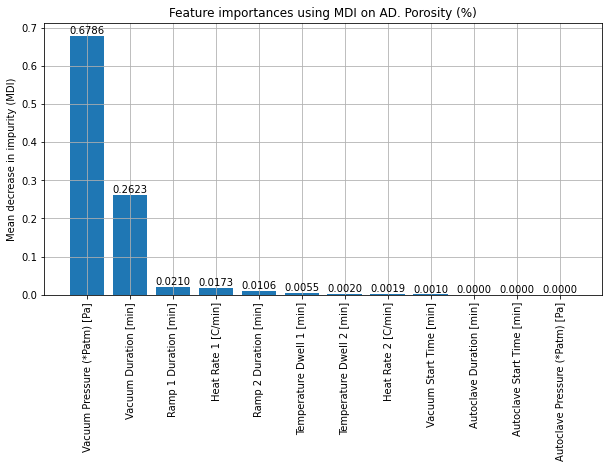

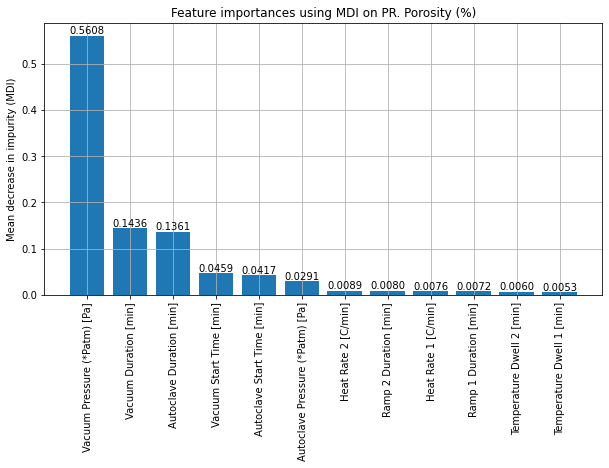

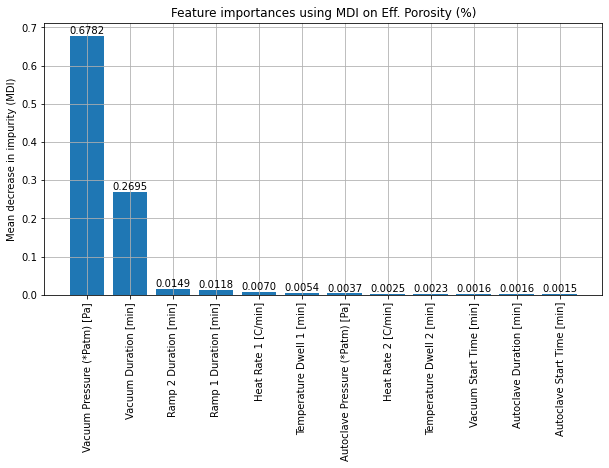

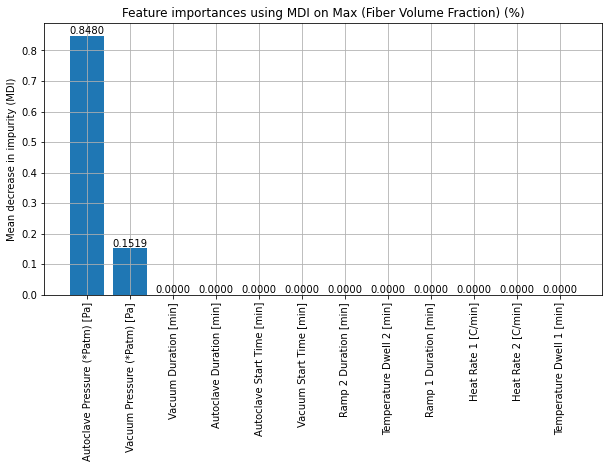

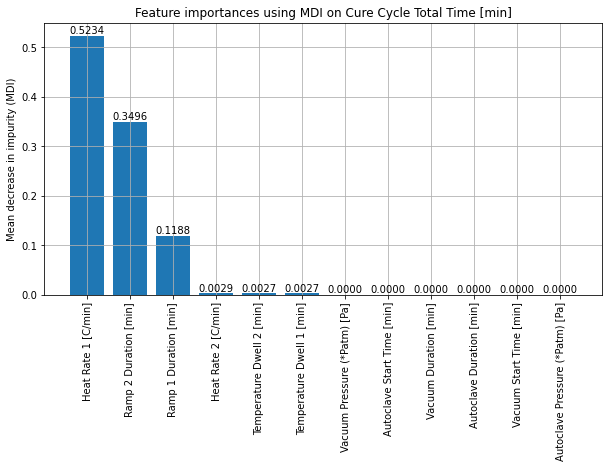

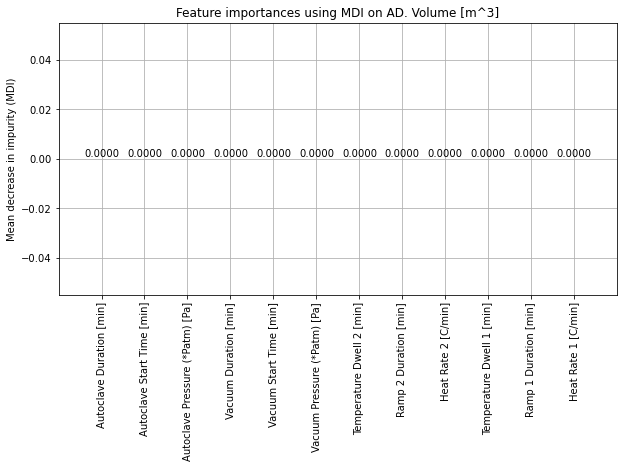

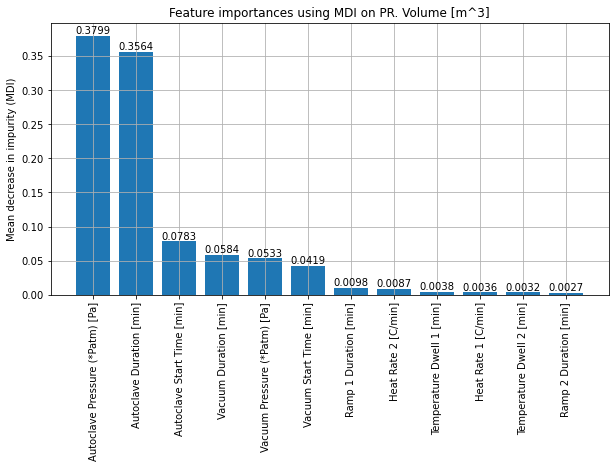

In [14]:
for index in range(7):
    
    output_name = output_labels[index]
    print(f"working on {output_name}...")
    y_train_, y_test_ = y_train[:,[index]], y_test[:, [index]]

    regression = RandomForestRegressor(random_state=0)
    multi_output_regression = MultiOutputRegressor(regression).fit(x_train, y_train_)

    #testing score
    print('Testing score: ', multi_output_regression.score(x_test, y_test_)*100, '%')
    print('Training score: ', multi_output_regression.score(x_train, y_train_)*100, '%')

    forest = multi_output_regression.estimators_[0]
    
    #plotting best features 
    plot_importances(forest, output_label = output_name)
    
